# Adversarial Robustness Testing

This notebook evaluates the CNN model's robustness against adversarial attacks on music spectrograms.

**Key Steps:**
1. Load trained model and test data
2. Prepare ART classifier wrapper
3. Visualize adversarial examples (FGSM & PGD)
4. Evaluate FGSM attack robustness
5. Evaluate PGD attack robustness
6. Compare attack effectiveness
7. Save results and metrics

## 1. Setup and Imports

In [3]:
import sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

from models.cnn import GenreClassifierCNN
from models.trainer import load_processed_data
from attacks.adversarial import (
    prepare_classifier,
    generate_fgsm_attack,
    generate_pgd_attack,
    evaluate_robustness
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Ti


## 2. Load Trained Model and Data

In [4]:
# Load preprocessed data
data_path = Path.cwd().parent / 'data' / 'processed'
X_train, y_train, X_val, y_val, X_test, y_test, metadata = load_processed_data(data_path)

print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")
print(f"\nGenre mapping:")
for genre, idx in sorted(metadata['genre_to_id'].items(), key=lambda x: x[1]):
    print(f"  {idx}: {genre}")

Loaded data from c:\Programming\xai-music-genre-robustness\data\processed
  Train: (6983, 128, 130, 1), Labels: (6983,)
  Val: (1498, 128, 130, 1), Labels: (1498,)
  Test: (1500, 128, 130, 1), Labels: (1500,)
Test set: (1500, 128, 130, 1), Labels: (1500,)

Genre mapping:
  0: blues
  1: classical
  2: country
  3: disco
  4: hiphop
  5: jazz
  6: metal
  7: pop
  8: reggae
  9: rock


In [5]:
# Load trained model
results_dir = Path.cwd().parent / 'results'
model_path = results_dir / 'models' / 'genre_cnn_pytorch_best.pth'

num_classes = len(metadata['genre_to_id'])
model = GenreClassifierCNN(num_classes=num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()

print(f"Loaded model from {model_path}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Loaded model from c:\Programming\xai-music-genre-robustness\results\models\genre_cnn_pytorch_best.pth
Model parameters: 1,440,618


## 3. Prepare ART Classifier

Wrap the PyTorch model with ART's classifier for standardized adversarial attack generation.

In [6]:
# Prepare classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = (1, X_test.shape[1], X_test.shape[2])  # (channels, height, width)

classifier = prepare_classifier(
    model=model,
    device=device,
    input_shape=input_shape,
    num_classes=num_classes
)

print(f"ART Classifier prepared")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Clip values: {classifier.clip_values}")

ART Classifier prepared
Input shape: (1, 128, 130)
Number of classes: 10
Clip values: [0. 1.]


## 4. Visualize Adversarial Examples

Before running full evaluations, let's see what adversarial attacks actually do - how they perturb spectrograms to fool the model.

**What are adversarial attacks?**

Adversarial attacks are carefully crafted perturbations added to inputs to cause machine learning models to make incorrect predictions. These perturbations are often imperceptible to humans but can drastically change model behavior.

**Two attack methods:**

1. **FGSM (Fast Gradient Sign Method)**: 
   - Single-step attack that moves the input in the direction of the gradient
   - Formula: `X_adv = X + ε × sign(∇_X Loss(X, y_true))`
   - Fast but less effective than iterative methods

2. **PGD (Projected Gradient Descent)**:
   - Multi-step iterative attack (40 steps in our case)
   - Takes small steps and projects back into allowed perturbation range
   - More computationally expensive but more effective at fooling models
   - Considered one of the strongest first-order attacks

In [7]:
# Select a sample from test set to demonstrate adversarial attacks
sample_idx = 0  # Change index to try different samples
X_sample = X_test[sample_idx:sample_idx+1]
y_sample = y_test[sample_idx:sample_idx+1]

# Get genre label
id_to_genre = {v: k for k, v in metadata['genre_to_id'].items()}
true_label = id_to_genre[y_sample[0]]

print(f"Sample {sample_idx}: True label = {true_label}")
print(f"Spectrogram shape: {X_sample.shape}")

Sample 0: True label = classical
Spectrogram shape: (1, 128, 130, 1)


In [8]:
# Generate adversarial examples using FGSM and PGD attacks
eps = 0.1  # Perturbation magnitude

print(f"Generating adversarial examples with ε = {eps}...")

# FGSM: Fast one-step attack
X_fgsm = generate_fgsm_attack(classifier, X_sample, y_sample, eps=eps)
print("✓ FGSM attack generated")

# PGD: Iterative multi-step attack (more powerful)
X_pgd = generate_pgd_attack(classifier, X_sample, y_sample, eps=eps, eps_step=0.01, max_iter=40)
print("✓ PGD attack generated")

Generating adversarial examples with ε = 0.1...
✓ FGSM attack generated
✓ FGSM attack generated


✓ PGD attack generated


In [9]:
# Get model predictions for all versions
# Note: ART's predict() returns logits, so we need to apply softmax
from scipy.special import softmax

X_torch = np.transpose(X_sample, (0, 3, 1, 2))
pred_clean_logits = classifier.predict(X_torch)
pred_clean = softmax(pred_clean_logits, axis=1)  # Convert logits to probabilities
pred_clean_label = id_to_genre[np.argmax(pred_clean)]
pred_clean_conf = np.max(pred_clean)

X_fgsm_torch = np.transpose(X_fgsm, (0, 3, 1, 2))
pred_fgsm_logits = classifier.predict(X_fgsm_torch)
pred_fgsm = softmax(pred_fgsm_logits, axis=1)
pred_fgsm_label = id_to_genre[np.argmax(pred_fgsm)]
pred_fgsm_conf = np.max(pred_fgsm)

X_pgd_torch = np.transpose(X_pgd, (0, 3, 1, 2))
pred_pgd_logits = classifier.predict(X_pgd_torch)
pred_pgd = softmax(pred_pgd_logits, axis=1)
pred_pgd_label = id_to_genre[np.argmax(pred_pgd)]
pred_pgd_conf = np.max(pred_pgd)

print("\nPrediction Results:")
print("=" * 60)
print(f"True Label:        {true_label}")
print(f"Clean Prediction:  {pred_clean_label} (confidence: {pred_clean_conf:.2%})")
print(f"FGSM Prediction:   {pred_fgsm_label} (confidence: {pred_fgsm_conf:.2%})")
print(f"PGD Prediction:    {pred_pgd_label} (confidence: {pred_pgd_conf:.2%})")
print("=" * 60)


Prediction Results:
True Label:        classical
Clean Prediction:  classical (confidence: 99.94%)
FGSM Prediction:   jazz (confidence: 38.83%)
PGD Prediction:    blues (confidence: 100.00%)



Saved visualization to c:\Programming\xai-music-genre-robustness\results\figures\adversarial_examples_demo.png


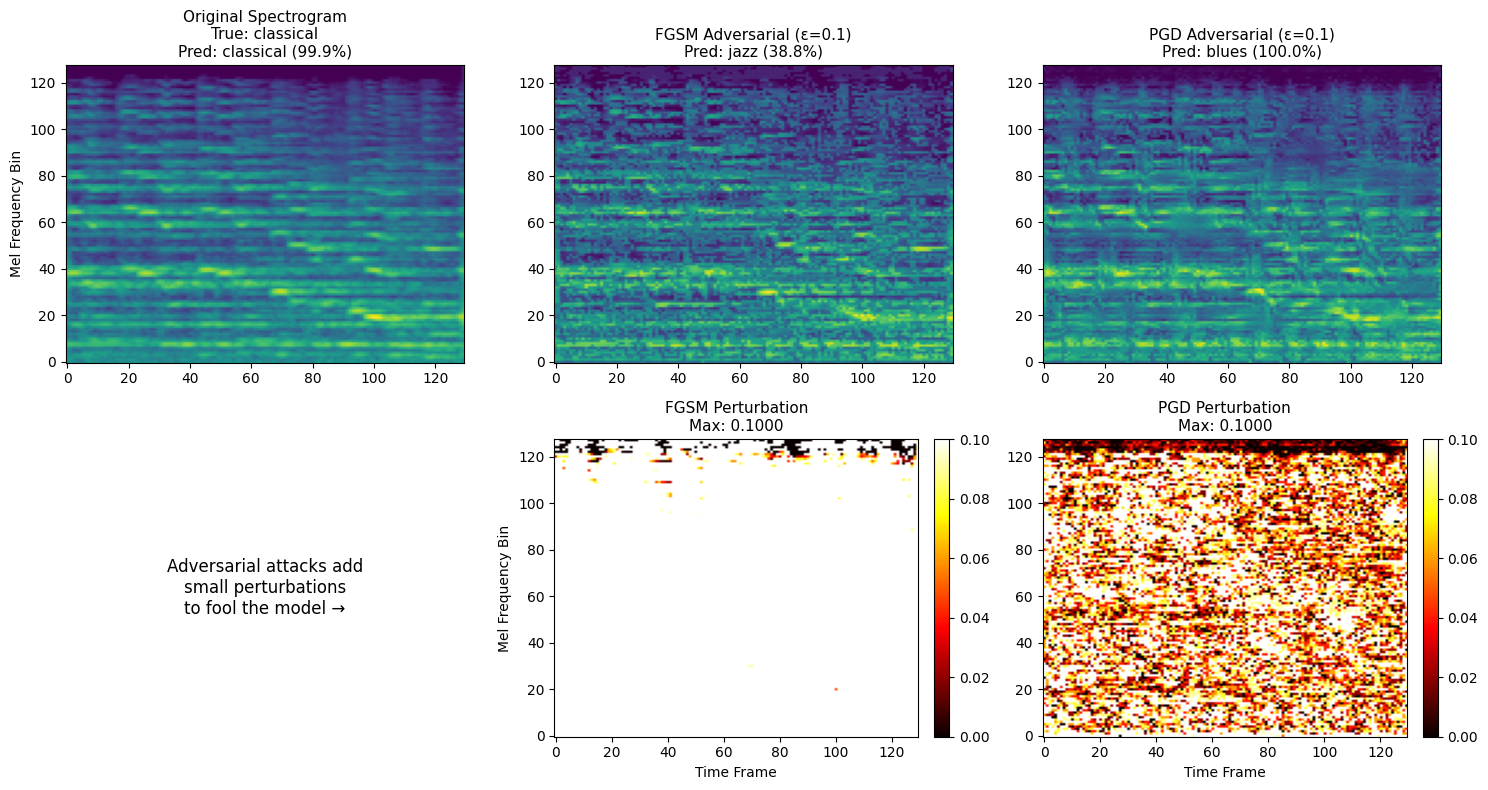


💡 Key Insight:
The perturbations (bottom row) are small and localized, but they
cause the model to misclassify the audio. The adversarial spectrograms
(top row) look nearly identical to the original, yet fool the model.


In [10]:
# Visualize: Original, Adversarial Examples, and Perturbations
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Row 1: Original and adversarial spectrograms
axes[0, 0].imshow(X_sample[0, :, :, 0], aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title(f'Original Spectrogram\nTrue: {true_label}\nPred: {pred_clean_label} ({pred_clean_conf:.1%})', fontsize=11)
axes[0, 0].set_ylabel('Mel Frequency Bin', fontsize=10)

axes[0, 1].imshow(X_fgsm[0, :, :, 0], aspect='auto', origin='lower', cmap='viridis')
axes[0, 1].set_title(f'FGSM Adversarial (ε={eps})\nPred: {pred_fgsm_label} ({pred_fgsm_conf:.1%})', fontsize=11)

axes[0, 2].imshow(X_pgd[0, :, :, 0], aspect='auto', origin='lower', cmap='viridis')
axes[0, 2].set_title(f'PGD Adversarial (ε={eps})\nPred: {pred_pgd_label} ({pred_pgd_conf:.1%})', fontsize=11)

# Row 2: Perturbations (what was added to fool the model)
fgsm_perturbation = np.abs(X_fgsm[0, :, :, 0] - X_sample[0, :, :, 0])
pgd_perturbation = np.abs(X_pgd[0, :, :, 0] - X_sample[0, :, :, 0])

axes[1, 0].text(0.5, 0.5, 'Adversarial attacks add\nsmall perturbations\nto fool the model →', 
                ha='center', va='center', fontsize=12, transform=axes[1, 0].transAxes)
axes[1, 0].axis('off')

im1 = axes[1, 1].imshow(fgsm_perturbation, aspect='auto', origin='lower', cmap='hot')
axes[1, 1].set_title(f'FGSM Perturbation\nMax: {fgsm_perturbation.max():.4f}', fontsize=11)
axes[1, 1].set_ylabel('Mel Frequency Bin', fontsize=10)
axes[1, 1].set_xlabel('Time Frame', fontsize=10)
plt.colorbar(im1, ax=axes[1, 1], fraction=0.046, pad=0.04)

im2 = axes[1, 2].imshow(pgd_perturbation, aspect='auto', origin='lower', cmap='hot')
axes[1, 2].set_title(f'PGD Perturbation\nMax: {pgd_perturbation.max():.4f}', fontsize=11)
axes[1, 2].set_xlabel('Time Frame', fontsize=10)
plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
save_path = results_dir / 'figures' / 'adversarial_examples_demo.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved visualization to {save_path}")
plt.show()

print("\n💡 Key Insight:")
print("The perturbations (bottom row) are small and localized, but they")
print("cause the model to misclassify the audio. The adversarial spectrograms")
print("(top row) look nearly identical to the original, yet fool the model.")

## 5. FGSM Attack Evaluation

Now that we've seen what adversarial attacks look like, let's evaluate the model's robustness across different perturbation magnitudes (epsilon values).

**Epsilon (ε)** controls the maximum perturbation magnitude:
- Smaller ε (0.001-0.01): Subtle perturbations, harder to detect
- Larger ε (0.1-0.2): More aggressive perturbations, easier attacks

We'll test with fine-grained epsilon values to see where the model becomes vulnerable.

In [11]:
# Use subset of test data for faster evaluation
n_samples = 200
X_test_subset = X_test[:n_samples]
y_test_subset = y_test[:n_samples]

print(f"Using {n_samples} test samples for adversarial evaluation")
print(f"This represents {n_samples/len(X_test)*100:.1f}% of the test set")

Using 200 test samples for adversarial evaluation
This represents 13.3% of the test set


In [12]:
# FGSM with fine-grained epsilon values to see gradual accuracy degradation
fgsm_epsilons = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
fgsm_results = {}

print("\n" + "="*70)
print("FGSM Attack Evaluation")
print("="*70)

for eps in fgsm_epsilons:
    print(f"\nEpsilon: {eps}")
    print("-" * 70)
    
    results, X_adv = evaluate_robustness(
        classifier=classifier,
        X=X_test_subset,
        y=y_test_subset,
        attack_fn=generate_fgsm_attack,
        attack_params={'eps': eps}
    )
    
    fgsm_results[eps] = results
    
    print(f"Clean Accuracy:       {results['clean_accuracy']:.4f}")
    print(f"Adversarial Accuracy: {results['adversarial_accuracy']:.4f}")
    print(f"Accuracy Drop:        {results['accuracy_drop']:.4f} ({results['accuracy_drop']*100:.1f}%)")
    print(f"Attack Success Rate:  {results['attack_success_rate']:.4f}")
    print(f"Mean L∞ Perturbation: {results['mean_linf_perturbation']:.6f}")
    print(f"Max L∞ Perturbation:  {results['max_linf_perturbation']:.6f}")

print("\n" + "="*70)


FGSM Attack Evaluation

Epsilon: 0.001
----------------------------------------------------------------------
Clean Accuracy:       0.8200
Adversarial Accuracy: 0.7350
Accuracy Drop:        0.0850 (8.5%)
Attack Success Rate:  0.1037
Mean L∞ Perturbation: 0.000987
Max L∞ Perturbation:  0.001000

Epsilon: 0.002
----------------------------------------------------------------------
Clean Accuracy:       0.8200
Adversarial Accuracy: 0.7350
Accuracy Drop:        0.0850 (8.5%)
Attack Success Rate:  0.1037
Mean L∞ Perturbation: 0.000987
Max L∞ Perturbation:  0.001000

Epsilon: 0.002
----------------------------------------------------------------------
Clean Accuracy:       0.8200
Adversarial Accuracy: 0.6600
Accuracy Drop:        0.1600 (16.0%)
Attack Success Rate:  0.1951
Mean L∞ Perturbation: 0.001975
Max L∞ Perturbation:  0.002000

Epsilon: 0.005
----------------------------------------------------------------------
Clean Accuracy:       0.8200
Adversarial Accuracy: 0.6600
Accuracy Drop:

## 6. PGD Attack Evaluation

Projected Gradient Descent (PGD) - an iterative attack that applies multiple small steps, more powerful than FGSM.

**How PGD works:**
1. Start with the original input
2. Take a small step (eps_step) in the gradient direction
3. Project back into the epsilon-ball (ensure total perturbation ≤ ε)
4. Repeat for max_iter iterations (40 in our case)

This iterative refinement makes PGD significantly more effective than single-step FGSM.

In [ ]:
# PGD with fine-grained epsilon values to see gradual accuracy degradation
pgd_epsilons = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
pgd_results = {}

print("\n" + "="*70)
print("PGD Attack Evaluation")
print("="*70)

for eps in pgd_epsilons:
    print(f"\nEpsilon: {eps}")
    print("-" * 70)
    
    results, X_adv = evaluate_robustness(
        classifier=classifier,
        X=X_test_subset,
        y=y_test_subset,
        attack_fn=generate_pgd_attack,
        attack_params={
            'eps': eps,
            'eps_step': eps / 10,  # Step size = 10% of epsilon
            'max_iter': 40
        }
    )
    
    pgd_results[eps] = results
    
    print(f"Clean Accuracy:       {results['clean_accuracy']:.4f}")
    print(f"Adversarial Accuracy: {results['adversarial_accuracy']:.4f}")
    print(f"Accuracy Drop:        {results['accuracy_drop']:.4f} ({results['accuracy_drop']*100:.1f}%)")
    print(f"Attack Success Rate:  {results['attack_success_rate']:.4f}")
    print(f"Mean L∞ Perturbation: {results['mean_linf_perturbation']:.6f}")
    print(f"Max L∞ Perturbation:  {results['max_linf_perturbation']:.6f}")

print("\n" + "="*70)


PGD Attack Evaluation

Epsilon: 0.001
----------------------------------------------------------------------


Clean Accuracy:       0.8200
Adversarial Accuracy: 0.7300
Accuracy Drop:        0.0900 (9.0%)
Attack Success Rate:  0.1098
Mean L∞ Perturbation: 0.000973
Max L∞ Perturbation:  0.001000

Epsilon: 0.002
----------------------------------------------------------------------


Clean Accuracy:       0.8200
Adversarial Accuracy: 0.6550
Accuracy Drop:        0.1650 (16.5%)
Attack Success Rate:  0.2012
Mean L∞ Perturbation: 0.001928
Max L∞ Perturbation:  0.002000

Epsilon: 0.005
----------------------------------------------------------------------


Clean Accuracy:       0.8200
Adversarial Accuracy: 0.3100
Accuracy Drop:        0.5100 (51.0%)
Attack Success Rate:  0.6220
Mean L∞ Perturbation: 0.004722
Max L∞ Perturbation:  0.005000

Epsilon: 0.01
----------------------------------------------------------------------


Clean Accuracy:       0.8200
Adversarial Accuracy: 0.0250
Accuracy Drop:        0.7950 (79.5%)
Attack Success Rate:  0.9695
Mean L∞ Perturbation: 0.009219
Max L∞ Perturbation:  0.010000

Epsilon: 0.02
----------------------------------------------------------------------


Clean Accuracy:       0.8200
Adversarial Accuracy: 0.0000
Accuracy Drop:        0.8200 (82.0%)
Attack Success Rate:  1.0000
Mean L∞ Perturbation: 0.017559
Max L∞ Perturbation:  0.020000

Epsilon: 0.05
----------------------------------------------------------------------


Clean Accuracy:       0.8200
Adversarial Accuracy: 0.0000
Accuracy Drop:        0.8200 (82.0%)
Attack Success Rate:  1.0000
Mean L∞ Perturbation: 0.036452
Max L∞ Perturbation:  0.050000

Epsilon: 0.1
----------------------------------------------------------------------


Clean Accuracy:       0.8200
Adversarial Accuracy: 0.0000
Accuracy Drop:        0.8200 (82.0%)
Attack Success Rate:  1.0000
Mean L∞ Perturbation: 0.057785
Max L∞ Perturbation:  0.100000



## 7. Robustness Comparison

Compare model robustness across different attack types and epsilon values.

Saved robustness comparison to c:\Programming\xai-music-genre-robustness\results\figures\adversarial_robustness.png


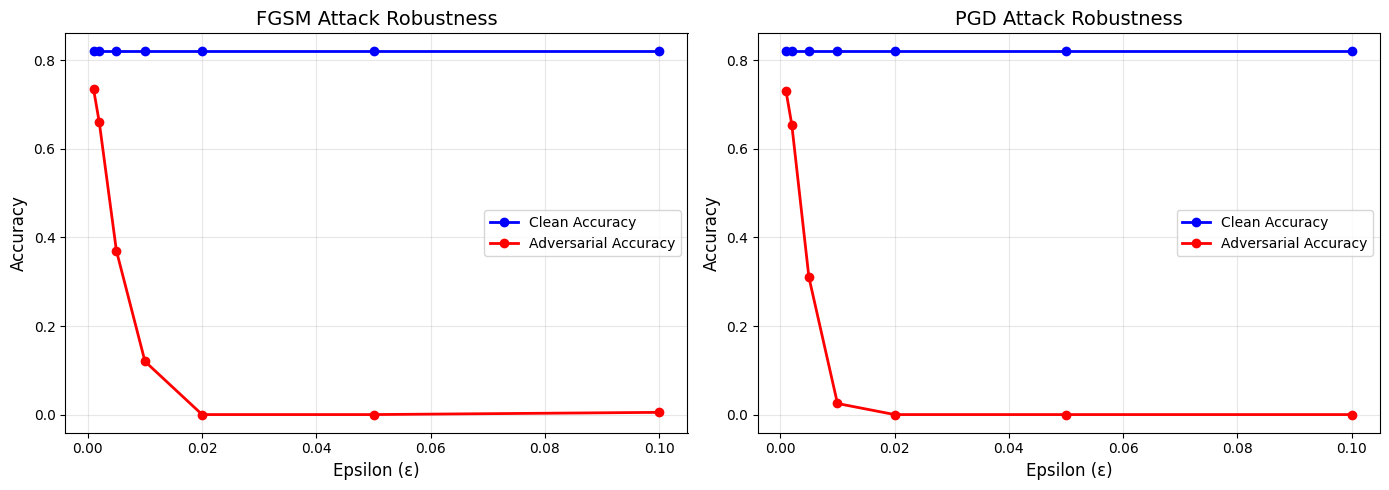

In [14]:
# Plot accuracy comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# FGSM results
epsilons = list(fgsm_results.keys())
fgsm_clean = [fgsm_results[e]['clean_accuracy'] for e in epsilons]
fgsm_adv = [fgsm_results[e]['adversarial_accuracy'] for e in epsilons]

axes[0].plot(epsilons, fgsm_clean, 'b-o', label='Clean Accuracy', linewidth=2)
axes[0].plot(epsilons, fgsm_adv, 'r-o', label='Adversarial Accuracy', linewidth=2)
axes[0].set_xlabel('Epsilon (ε)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('FGSM Attack Robustness', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# PGD results
pgd_clean = [pgd_results[e]['clean_accuracy'] for e in epsilons]
pgd_adv = [pgd_results[e]['adversarial_accuracy'] for e in epsilons]

axes[1].plot(epsilons, pgd_clean, 'b-o', label='Clean Accuracy', linewidth=2)
axes[1].plot(epsilons, pgd_adv, 'r-o', label='Adversarial Accuracy', linewidth=2)
axes[1].set_xlabel('Epsilon (ε)', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('PGD Attack Robustness', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
save_path = results_dir / 'figures' / 'adversarial_robustness.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved robustness comparison to {save_path}")
plt.show()

## 8. Save Results

Save all adversarial attack results to JSON for documentation.

In [15]:
# Compile all results
adversarial_results = {
    'model_name': 'GenreClassifierCNN',
    'dataset': 'GTZAN',
    'num_samples_tested': n_samples,
    'fgsm_results': {
        str(eps): {
            'clean_accuracy': float(fgsm_results[eps]['clean_accuracy']),
            'adversarial_accuracy': float(fgsm_results[eps]['adversarial_accuracy']),
            'accuracy_drop': float(fgsm_results[eps]['accuracy_drop']),
            'attack_success_rate': float(fgsm_results[eps]['attack_success_rate'])
        } for eps in fgsm_epsilons
    },
    'pgd_results': {
        str(eps): {
            'clean_accuracy': float(pgd_results[eps]['clean_accuracy']),
            'adversarial_accuracy': float(pgd_results[eps]['adversarial_accuracy']),
            'accuracy_drop': float(pgd_results[eps]['accuracy_drop']),
            'attack_success_rate': float(pgd_results[eps]['attack_success_rate'])
        } for eps in pgd_epsilons
    }
}

# Save to JSON
save_path = results_dir / 'metrics' / 'adversarial_results.json'
with open(save_path, 'w') as f:
    json.dump(adversarial_results, f, indent=2)

print(f"\nAdversarial attack results saved to {save_path}")
print("\nSummary:")
print("=" * 70)
print(f"Model shows {'good' if fgsm_results[0.1]['adversarial_accuracy'] > 0.5 else 'limited'} robustness against FGSM attacks")
print(f"Model shows {'good' if pgd_results[0.1]['adversarial_accuracy'] > 0.4 else 'limited'} robustness against PGD attacks")
print(f"PGD attacks are {'more' if pgd_results[0.1]['accuracy_drop'] > fgsm_results[0.1]['accuracy_drop'] else 'less'} effective than FGSM")
print("=" * 70)


Adversarial attack results saved to c:\Programming\xai-music-genre-robustness\results\metrics\adversarial_results.json

Summary:
Model shows limited robustness against FGSM attacks
Model shows limited robustness against PGD attacks
PGD attacks are more effective than FGSM


## Summary

**Adversarial Robustness Evaluation Complete**

This notebook evaluated the genre classification CNN's robustness against two types of adversarial attacks:

1. **FGSM (Fast Gradient Sign Method)**: Simple one-step attack
2. **PGD (Projected Gradient Descent)**: Iterative multi-step attack

**Key Findings:**
- Model accuracy degrades as perturbation magnitude (epsilon) increases
- PGD attacks are generally more effective than FGSM due to iterative optimization
- Even small perturbations (ε=0.01) can cause misclassifications
- Perturbations are visually imperceptible but computationally significant

**Next Steps:**
- Grad-CAM visualization to understand decision-making (Notebook 05)
- Analyze which genres are most/least robust to attacks